In [213]:
import torch
import matplotlib.pylab as plt
import imageio 
import numpy as np 
import numpy as np
from timeit import repeat
import matplotlib.pyplot as plt
import cvxpy as cp
import learnreg as lr
import opt
import reports
import scipy.io
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:

n = 64
#signal_type = 'DCT-sparse'
signal_type = 'piecewise_constant'
num_signals = 100

k = n   # just to keep track of shapes
forward_model_type = 'identity'
noise_sigma = 0.05

transform_type = 'identity'
transform_scale = 1e-1
transform_opts = {"k":n}
threshold = 1e-6

random_seed = 0


plt.close('all')

np.random.seed(random_seed)
A = lr.make_forward_model(forward_model_type, n)
#A = lr.make_forward_model(forward_model_type, n,np.add(list(range(10)), int(n/2 -20)).tolist())
#A = lr.make_forward_model(forward_model_type, n,np.random.choice(n,10).tolist())
#W = lr.make_transform(transform_type, n, transform_scale,**transform_opts)
train = lr.make_dataset(signal_type, A, noise_sigma, num_signals)


In [206]:


def learn_analysis_unsupervised(X, num_atoms,
                                rho = 1.0, num_iters=10):
    """
    returns argmin_W \sum_i |[WX]_i|,
    which is just a generalization of argmin_W \| Wx \|_1 that allows
    patches as columns of X

    The approach will be ADMM scaled form (3.1.1 in 
    'Distributed Optimization and Statistical Learning via the Alternating DirectionMethod of Multipliers"
    """

    num_patches = X.shape[1]

    def procrustes(A, B):
        """
        returns argmin_W \|WA - B\|_F s.t. W^TW = I

        [1] https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem
        """
        M = B.matmul(A.t())
        U, S, V = M.svd()
        return U.matmul(V.t())

    def soft_threshold(a):
        """
        Distributed Optimization and Statistical Learning... 4.4.3 and 
        """
        
        k = 1/rho
        out = torch.zeros_like(a)
        out[a > k] = (a - k)[a > k]
        out[a < -k] = (a + k)[a < -k]
        return out

    z = torch.zeros((num_atoms, num_patches), dtype=X.dtype, device=X.device)
    u = torch.zeros_like(z)

    for iter in range(num_iters):
        W = procrustes(X, z-u)
        WX = W.matmul(X)
        print(WX.abs().sum(), (WX-z).pow(2).sum())
        z = soft_threshold(WX + u)
        u = u + WX - z

    return W

def im2col(x, size):
    x = x.unfold(0, size=size, step=1)
    x = x.unfold(1, size=size, step=1)
    return x.reshape((-1, size**2)).t()

In [209]:
#x_patches = im2col(torch.from_numpy(x), 8)
W = learn_analysis_unsupervised(torch.from_numpy(x), 64, rho=10.0,num_iters = 50)
 

tensor(320565.5389, dtype=torch.float64) tensor(213768.1458, dtype=torch.float64)
tensor(320562.4431, dtype=torch.float64) tensor(5983.3048, dtype=torch.float64)
tensor(320560.0690, dtype=torch.float64) tensor(53.0241, dtype=torch.float64)
tensor(320556.6786, dtype=torch.float64) tensor(11.5317, dtype=torch.float64)
tensor(320552.0363, dtype=torch.float64) tensor(4.9915, dtype=torch.float64)
tensor(320545.5044, dtype=torch.float64) tensor(3.0501, dtype=torch.float64)
tensor(320536.4113, dtype=torch.float64) tensor(2.4044, dtype=torch.float64)
tensor(320523.6833, dtype=torch.float64) tensor(2.3970, dtype=torch.float64)
tensor(320506.0144, dtype=torch.float64) tensor(2.8677, dtype=torch.float64)
tensor(320481.7707, dtype=torch.float64) tensor(3.7348, dtype=torch.float64)
tensor(320448.3660, dtype=torch.float64) tensor(5.0881, dtype=torch.float64)
tensor(320401.3178, dtype=torch.float64) tensor(7.0712, dtype=torch.float64)
tensor(320334.6743, dtype=torch.float64) tensor(9.9310, dtype=torc

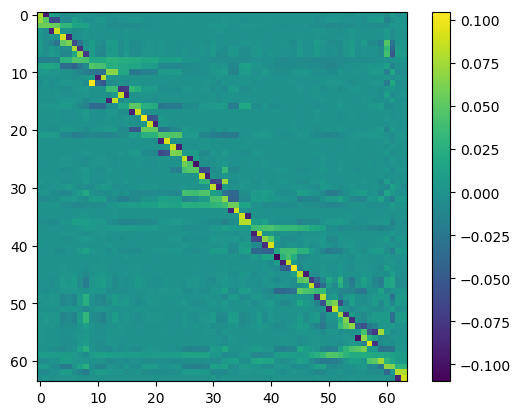

In [261]:
plt.imshow(W)
plt.colorbar()
plt.savefig('ICASSP_rebuttal/analysis_dict.png')
plt.show()

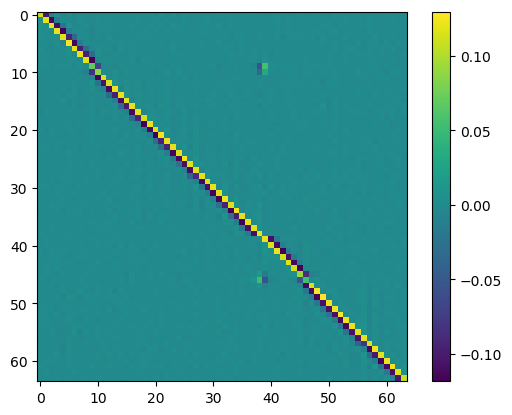

In [263]:
Wtv=np.load('Wsupervised_learned.npy')
plt.imshow(Wtv)
plt.colorbar()
plt.savefig('ICASSP_rebuttal/LearnedTV.png')
plt.show()

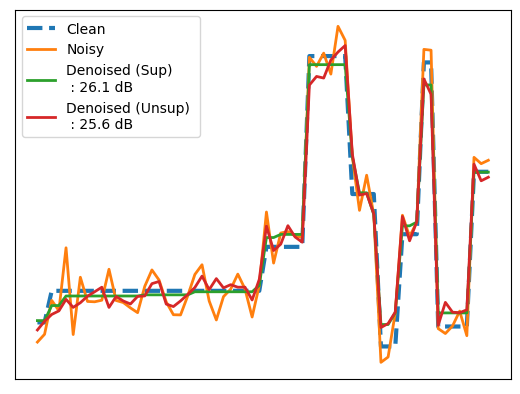

In [262]:
beta_sup=1
beta_unsup = 0.7
for i in range(15):
    x_sup = opt.solve_lasso(A,train.y[:,i], beta_sup, W_tvlearn)
    x_unsup = opt.solve_lasso(A,train.y[:,i], beta_unsup, Wtv)

    plt.plot(train.x[:,i], linestyle='dashed',label='Clean', linewidth=3)
    plt.plot(train.y[:,i],label = 'Noisy', linewidth=2)
    plt.plot(x_sup,label = 'Denoised (Sup) \n :',lr.PSNR(x_sup,train.x[i]), linewidth=2)
    plt.plot(x_unsup,label = 'Denoised (Unsup) \n :', lr.PSNR(x_unsup,train.x[i]),linewidth=2)
    plt.legend(loc=2,fontsize=10)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("ICASSP_rebuttal/1DTV_comparision.png", format="png")
    plt.show()
